In [1]:
%load_ext autoreload
%autoreload 2

import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cosine sim
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.linear_model import SGDClassifier
# import mlp
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
# import pca
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
import pickle
import run_all
from run_all import fit_optimal_transport
import torch
import tqdm
import ot

In [2]:

encondings = []
batch_size = 64

@torch.no_grad
def encode(model, tokenizer, text, batch_size, ln=None,layer=-1):
  encodings_last, encodings_mean = [], []
  with torch.no_grad():
   for i in tqdm.tqdm(range(0, len(text), batch_size)):
    batch = text[i:i+batch_size]
    padded_tokens = tokenizer(batch, padding=True, return_tensors="pt", max_length=300, truncation=True).to("cuda")
    with torch.no_grad():
      outputs = model(**padded_tokens, output_hidden_states=True)
      lengths = padded_tokens["attention_mask"].sum(axis=1).detach().cpu().numpy()

    hiddens = outputs.hidden_states[layer]#.detach().cpu().numpy()
    if ln is not None:
      hiddens = ln(hiddens)
    hiddens = hiddens.detach().cpu().numpy()
    del outputs
    torch.cuda.empty_cache()
    #lengths = padded_tokens["attention_mask"].sum(axis=1)
    
    for h,l in zip(hiddens, lengths):
      encodings_last.append(h[l-1].tolist())
      # take the mean, without the clst
      mean = h[:l].mean(axis=0)
      encodings_mean.append(mean.tolist())
  
  return np.array(encodings_last), np.array(encodings_mean)

In [51]:
with open("bios_data/bios_data/bios_train.pickle", "rb") as f:
  bios_train = pickle.load(f)

with open("bios_data/bios_data/bios_dev.pickle", "rb") as f:
  bios_dev = pickle.load(f)

with open("bios_data/bios_data/bios_test.pickle", "rb") as f:
  bios_test = pickle.load(f)

# path = "bios_data/bios_data/"
# model_name = "bert"
# rep_type = "cls"

# if model_name != "bert":
#   train_cls = np.load(file=path+"bios_train_{}_model={}.npy".format(rep_type, model_name), allow_pickle=True)
#   dev_cls = np.load(file=path+"bios_dev_{}_model={}.npy".format(rep_type, model_name), allow_pickle=True)
# else:
#   train_cls = np.load(file=path+"train_cls.npy".format(rep_type, model_name), allow_pickle=True)
#   dev_cls = np.load(file=path+"dev_cls.npy".format(rep_type, model_name), allow_pickle=True)


In [4]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [52]:
model_name="llama2"
train_cls  = np.load(file="bios_data/bios_data/Llama-2-7b-chat-hf_train.npy", allow_pickle=True)
dev_cls  = np.load(file="bios_data/bios_data/Llama-2-7b-chat-hf_test.npy", allow_pickle=True)

with open("bios_data/bios_data/pca_{}.pickle".format("llama2"), "rb") as f:
  pca = pickle.load(f)



In [6]:
# pca_dim = 768
# pca = PCA(n_components=pca_dim, random_state=0)
# pca.fit(train_cls)

# train_cls = pca.transform(train_cls)
# dev_cls = pca.transform(dev_cls)
# # save train and dev cls
# np.save("bios_data/bios_data/Llama-2-7b-chat-hf_train_pca.npy", train_cls)
# np.save("bios_data/bios_data/Llama-2-7b-chat-hf_test_pca.npy", dev_cls)

In [62]:
train_cls = np.load(file="bios_data/bios_data/Llama-2-7b-chat-hf_train_pca.npy", allow_pickle=True)
dev_cls = np.load(file="bios_data/bios_data/Llama-2-7b-chat-hf_dev_pca.npy", allow_pickle=True)

In [63]:
dev_cls.shape

(39369, 768)

In [54]:
with open("erased_llama2.pickle", "rb") as f:
    d = pickle.load(f)

    train_cls_erased, dev_cls_erased = d["train"], d["dev"]

In [55]:

prefix = ""
text_train = [prefix+d["hard_text"] for d in bios_train]
text_dev = [prefix+d["hard_text"] for d in bios_dev]
text_test = [prefix+d["hard_text"] for d in bios_test]

In [56]:
text_train[:5]

['She has been working with children in camp , community and school settings for the past 8 years . She believes in the importance of cultivating self - love and awareness in black children at a very young age and is excited to be apart of Black Lives Matter Toronto ’s Freedom School !',
 'He holds a PhD in Biosystems Engineering from University College Dublin ( Ireland ) . He previously held academic positions at University College Dublin ( Ireland ) , Dublin Institute of Technology ( Ireland ) and Harper Adams University ( UK ) . He was a PhD research assistant at Teagasc Irish Agriculture and Food Development Authority . His current research focus is on PLF applications , focussing on real - time modelling and control of animal bio - responses . Tomas started as daily coordinator of the EU - PLF project ( 2012 - 2016 ) and now coordinates 4 Ph.D. students and Masters students in PLF at M3-BIORES . He is PI and co - PI on collaborative National and International projects . He also co

In [64]:
z_train = np.array([0 if d["g"] == "f" else 1 for d in bios_train])
z_dev = np.array([0 if d["g"] == "f" else 1 for d in bios_dev])
y_train = np.array([d["p"] for d in bios_train])
y_dev =  np.array([d["p"] for d in bios_dev])


## apply OLCs

In [13]:
train_cls, z_train = train_cls[:], z_train[:]
mlp = MLPClassifier(hidden_layer_sizes=(128), early_stopping=True)
mlp.fit(train_cls, z_train)

z_labels_train = z_train
z_dev_pred = mlp.predict(dev_cls)
z_labels_dev = z_dev_pred
        
x_train_source = train_cls[z_labels_train==0]
x_train_target = train_cls[z_labels_train==1]

ot_linear = ot.da.LinearTransport(reg=1e-5)
ot_linear.fit(Xs=x_train_source, Xt=x_train_target)

# save mlp and ot

with open("mlp_ot.pickle", "wb") as f:
    pickle.dump({"mlp": mlp, "ot": ot_linear}, f)
    


In [65]:
# load
with open("mlp_ot.pickle", "rb") as f:
    d = pickle.load(f)
    mlp = d["mlp"]
    ot_linear = d["ot"]

In [66]:

z_train_pred = mlp.predict(train_cls)
z_dev_pred = mlp.predict(dev_cls)
z_labels_dev = z_dev_pred
z_labels_train = z_train_pred

x_dev_source = dev_cls[z_labels_dev==0]
x_dev_target = dev_cls[z_labels_dev==1]

train_x_transformed = train_cls.copy()
x_train_source = train_cls[z_labels_train==0]
x_train_target = train_cls[z_labels_train==1]
train_x_transformed[z_labels_train==0] = ot_linear.transform(Xs=x_train_source)

dev_x_transformed = dev_cls.copy()
dev_x_transformed[z_labels_dev==0] = ot_linear.transform(Xs=x_dev_source)


In [67]:
mlp.score(dev_cls, z_dev)

0.9690111509055348

## steering counterfactuals

In [68]:
train_x_transformed_steering = train_cls.copy()
dev_x_transformed_steering = dev_cls.copy()

mean_diff_vec = x_train_target.mean(axis=0) - x_train_source.mean(axis=0)

train_x_transformed_steering[z_labels_train==0] += 1*mean_diff_vec
dev_x_transformed_steering[z_labels_dev==0] += 1*mean_diff_vec


## bias by neighbors

In [69]:
# cosine sim
from sklearn.metrics.pairwise import cosine_similarity

def get_closest_neighbors( vecs, sents, ind, sims_all, top_k=5):
    vec = vecs[ind]
    sims = sims_all[ind] #cosine_similarity(vec.reshape(1, -1), vecs)[0]
    sorted_sims = np.argsort(sims)[::-1]
    closest_idx = sorted_sims[1:top_k+1]
    closest_sents = [sents[i] for i in closest_idx]
    return closest_sents, closest_idx


def record_bias_by_neigbhbor(vecs, sents, genders, num_samples=500, topk=25):

    mean_gender, mean_same_gender = [], []
    vecs = vecs[:30000]
    sims_all = cosine_similarity(vecs)
    for i in tqdm.tqdm(range(num_samples)):

        ind = np.random.randint(0, len(vecs))
        gender = genders[ind]

        closest_sents, closest_idx = get_closest_neighbors(vecs, sents, ind, sims_all, top_k=topk)
        neighbors_gender = [genders[i] for i in closest_idx]
        is_same_gender = [gender == n_gender for n_gender in neighbors_gender]

        mean_gender.append(np.mean(neighbors_gender))
        mean_same_gender.append(np.mean(is_same_gender))
    
    return np.mean(mean_gender), np.mean(mean_same_gender)

In [70]:
from collections import defaultdict
topk2bias = defaultdict(dict)
for topk in [1,4,8,16,32,64]:
    print(topk)
    bias_transformed = record_bias_by_neigbhbor(dev_x_transformed, text_dev, z_dev, num_samples=1000, topk=topk)
    bias_transformed_steering = record_bias_by_neigbhbor(dev_x_transformed_steering, text_dev, z_dev, num_samples=1000, topk=topk)
    bias_cls = record_bias_by_neigbhbor(dev_cls, text_dev, z_dev, num_samples=1000, topk=topk)
    topk2bias[topk]["transformed"] = bias_transformed
    topk2bias[topk]["transformed_steering"] = bias_transformed_steering
    topk2bias[topk]["cls"] = bias_cls
    print(bias_transformed, bias_transformed_steering, bias_cls)
    print("========")

1


100%|██████████| 1000/1000 [00:01<00:00, 981.21it/s]


(0.524, 0.614) (0.508, 0.739) (0.526, 0.854)
4


100%|██████████| 1000/1000 [00:00<00:00, 1027.09it/s]


(0.54325, 0.60075) (0.4995, 0.7105) (0.54375, 0.86025)
8


100%|██████████| 1000/1000 [00:01<00:00, 933.30it/s]


(0.5315, 0.584) (0.522, 0.70975) (0.525, 0.83475)
16


100%|██████████| 1000/1000 [00:00<00:00, 1029.95it/s]


(0.54, 0.57975) (0.5114375, 0.6875625) (0.491, 0.831)
32


100%|██████████| 1000/1000 [00:00<00:00, 1022.29it/s]


(0.52696875, 0.56196875) (0.51328125, 0.66415625) (0.5153125, 0.8154375)
64


100%|██████████| 1000/1000 [00:01<00:00, 999.34it/s]

(0.532015625, 0.555296875) (0.518890625, 0.641140625) (0.5266875, 0.80415625)


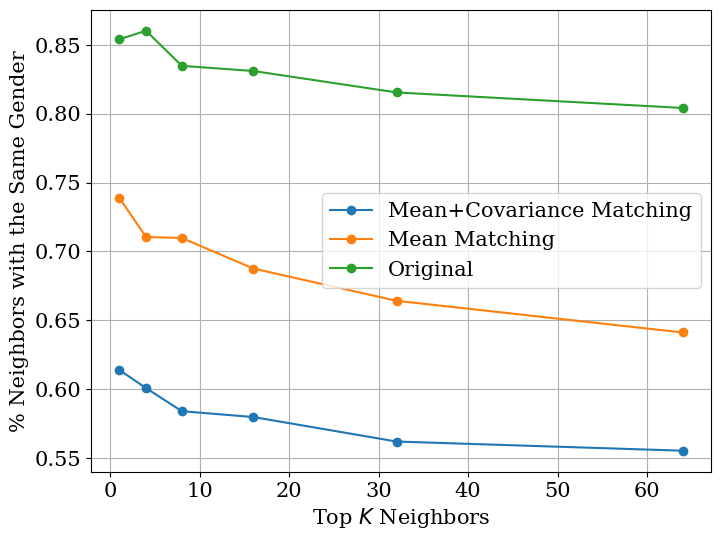

In [71]:
# plot curves of bias by neighbors vs topk, for all 3 methods
plt.rcParams["font.family"] = "serif"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

# set plot size

plt.figure(figsize=(8, 6))

plt.plot(list(topk2bias.keys()), [v["transformed"][1] for v in topk2bias.values()], label="Mean+Covariance Matching",
         marker="o")
plt.plot(list(topk2bias.keys()), [v["transformed_steering"][1] for v in topk2bias.values()], label="Mean Matching",
         marker="o")
plt.plot(list(topk2bias.keys()), [v["cls"][1] for v in topk2bias.values()], label="Original",
         marker="o")

plt.xlabel("Top $K$ Neighbors", fontsize=15)
plt.ylabel("% Neighbors with the Same Gender", fontsize=15)

plt.legend(fontsize=15)
plt.grid()
plt.savefig("topk_vs_bias.pdf", dpi=500)
plt.show()


## plot similarity matrix

In [72]:
dev_male = dev_x_transformed[z_dev==1]
dev_female = dev_x_transformed[z_dev==0]
n=2000
dev_all_sorted = np.concatenate([dev_male[:n], dev_female[:n]])
sims =cosine_similarity(dev_all_sorted)

In [73]:
dev_male = dev_cls[z_dev==1]
dev_female = dev_cls[z_dev==0]
dev_all_sorted_before = np.concatenate([dev_male[:n], dev_female[:n]])
sims_before = cosine_similarity(dev_all_sorted_before)

In [74]:
dev_male = dev_x_transformed_steering[z_dev==1]
dev_female = dev_x_transformed_steering[z_dev==0]
dev_all_sorted_steering = np.concatenate([dev_male[:n], dev_female[:n]], axis=0)
sims_steering = cosine_similarity(dev_all_sorted_steering)

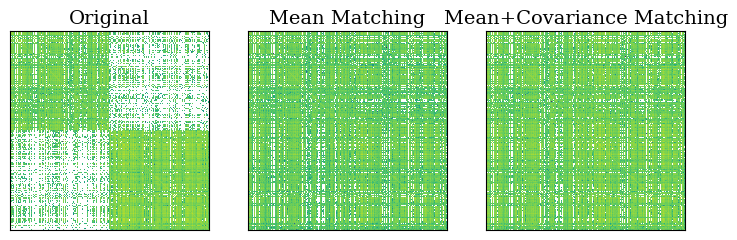

In [75]:
# plot sim before and after, side by side
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(sims_before, norm="log")
ax[1].imshow(sims_steering, norm="log")
ax[2].imshow(sims, norm="log")

ax[0].set_title("Original", fontsize=14)
ax[1].set_title("Mean Matching", fontsize=14)
ax[2].set_title("Mean+Covariance Matching", fontsize=14)

# add a colorbar for both plots together
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(ax[0].imshow(sims_before, norm="log"), cax=cbar_ax)
# remove xticks and yticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# remove colorbar
cbar_ax.set_visible(False)

plt.savefig("sim_before_after_llama2.pdf", dpi=500, bbox_inches="tight")
plt.show()


## train linear classifier on the original and trasnformed representations

In [77]:
def train_torch_logistic_classifier(x_train, y_train, batch_size=1024, num_epochs=100):

    # train a linear multiclass logistic regression (softmax) classifier
    num_classes = len(np.unique(y_train))
    clf = torch.nn.Sequential(
        torch.nn.Linear(x_train.shape[1], num_classes),
        torch.nn.Softmax(dim=1)
    )

    clf.to("cuda")
    x_train = torch.tensor(x_train).to("cuda").float()
    y2int = {y:i for i,y in enumerate(sorted(set(y_train)))}
    y_train = torch.tensor([y2int[yy] for yy in y_train]).to("cuda")

    loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(clf.parameters())

    for i in tqdm.tqdm(range(num_epochs)):
        for j in range(0, len(x_train), batch_size):
            batch_idx = np.random.choice(len(x_train), batch_size)
            x_batch = x_train[batch_idx]
            y_batch = y_train[batch_idx]
            y_pred = clf(x_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return clf


def calc_accuracy(clf, x, y):
    x_torch = torch.tensor(x).to("cuda").float()
    y2int = {y:i for i,y in enumerate(sorted(set(y)))}
    y_int = torch.tensor([y2int[yy] for yy in y]).to("cpu")
    y_pred = clf(x_torch).cpu().argmax(axis=1)
    return (y_pred == y_int).float().mean()


def get_predictions(clf, x):

    x_torch = torch.tensor(x).to("cuda").float()
    y_pred = clf(x_torch).cpu().argmax(axis=1)
    return y_pred.numpy()

In [89]:
clf_before = train_torch_logistic_classifier(train_x_transformed, y_train)
acc_before = calc_accuracy(clf_before, dev_x_transformed, y_dev)
acc_before

100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


tensor(0.7868)

In [79]:
clf_after = train_torch_logistic_classifier(train_x_transformed, y_train)
acc_after = calc_accuracy(clf_after, dev_x_transformed, y_dev)
print(acc_after)

100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

tensor(0.7835)


In [81]:

clf_after_steering = train_torch_logistic_classifier(train_x_transformed_steering, y_train)
acc_after_steering = calc_accuracy(clf_after_steering, dev_x_transformed_steering, y_dev)
print(acc_after_steering)

100%|██████████| 100/100 [00:27<00:00,  3.64it/s]

tensor(0.7975)


In [82]:
# clf_after_erasing = SGDClassifier(loss="log_loss", penalty="l2", max_iter=20000, tol=1e-4, random_state=0)
# clf_after_erasing.fit(train_cls_erased[:n], y_train[:n])
# clf_after_erasing.score(dev_cls_erased[:n], y_dev[:n])


# with open("clfs/llama2_cls_after_erasure.pickle", "wb") as f:
#   pickle.dump(clf_after_erasing, f)

clf_after_erasing = train_torch_logistic_classifier(train_cls_erased, y_train)
acc_after_erasing = calc_accuracy(clf_after_erasing, dev_cls_erased, y_dev)
print(acc_after_erasing)

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

tensor(0.7949)


## bias

In [91]:
y2int = {y:i for i,y in enumerate(sorted(set(y_train)))}
int2y = {i:y for y,i in y2int.items()}
y_pred = get_predictions(clf_after, dev_x_transformed) #get_predictions(clf_after_erasing, dev_cls_erased) #prof_clf.predict(dev_x_transformed)
y_pred = np.array([int2y[i] for i in y_pred])
y_pred_original = get_predictions(clf_before, dev_cls) #prof_clf.predict(dev_x_transformed
y_pred_original = np.array([int2y[i] for i in y_pred_original])
y_pred_true = y_pred[y_pred==y_dev]
z_pred_true = z_dev[y_pred==y_dev]


rms_tpr_gap = 0.0
rms_tpr_gap_orig = 0.0
prof2tpr = {}
prof2tpr_original = {}
prof2percentfem = {}
for y in set(y_pred_true):
  #y_pred[y_train == y] == y
  tpr_1 = (((y_pred[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
  tpr_0 =  (((y_pred[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
  rms_tpr_gap += (tpr_1 - tpr_0)**2
  prof2tpr[y] = (tpr_1 - tpr_0)**2

  tpr_1_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
  tpr_0_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
  rms_tpr_gap_orig += (tpr_1_original - tpr_0_original)**2
  prof2tpr_original[y] = (tpr_1_original - tpr_0_original)

  prof2percentfem[y] = 1-z_train[y_train==y].mean()
rms_tpr_gap = np.sqrt(rms_tpr_gap/len(set(y_pred_true)))
rms_tpr_gap_orig = np.sqrt(rms_tpr_gap_orig/len(set(y_pred_true)))
print(rms_tpr_gap, rms_tpr_gap_orig)

0.0948112987832523 0.18104860866489028


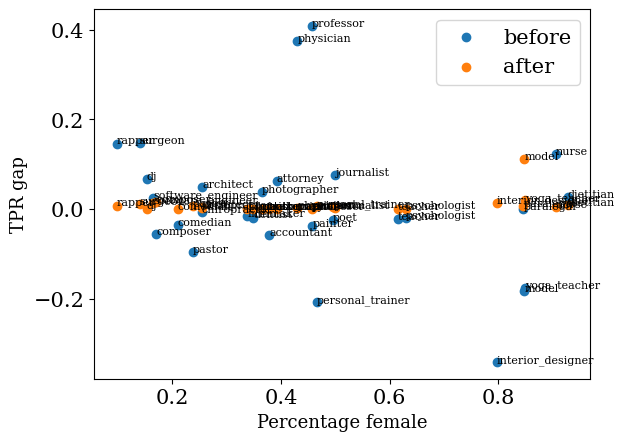

In [87]:
# plot percent fem vs tpr. add annotation with profession names
plt.scatter(list(prof2percentfem.values()), list(prof2tpr_original.values()), label="before")
plt.scatter(list(prof2percentfem.values()), list(prof2tpr.values()), label="after")

for i, txt in enumerate(list(prof2percentfem.keys())):
  plt.annotate(txt, (list(prof2percentfem.values())[i], list(prof2tpr.values())[i]), fontsize=8)
  plt.annotate(txt, (list(prof2percentfem.values())[i], list(prof2tpr_original.values())[i]), fontsize=8)

plt.xlabel("Percentage female", fontsize=13)
plt.ylabel("TPR gap", fontsize=13)
plt.legend()

#plt.savefig("gdrive/MyDrive/interventions/plots/" + "tpr_vs_female_bert.pdf", dpi=500)